In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

<IPython.core.display.Javascript object>


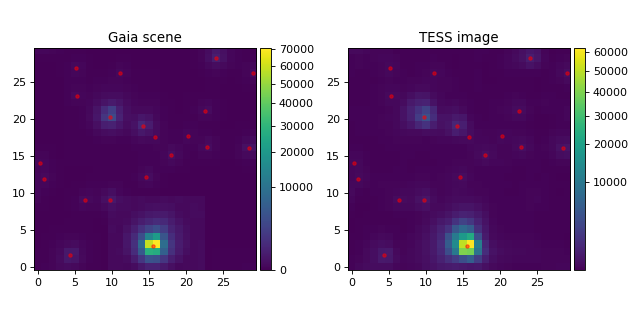

In [4]:
# single star
ra =  95.4586
dec = -51.2377
# SN2020fhw
#ra = 64.5261250     
#dec = -63.6150694
# GRB 
ra = 30.26933 
dec = 24.50988

size = 20
scene,tpf = sd.Gaia_scene(ra,dec,30,16,Interpolate=False,FFT=True,Plot = True,Save='Gaia_scene.pdf')

<IPython.core.display.Javascript object>


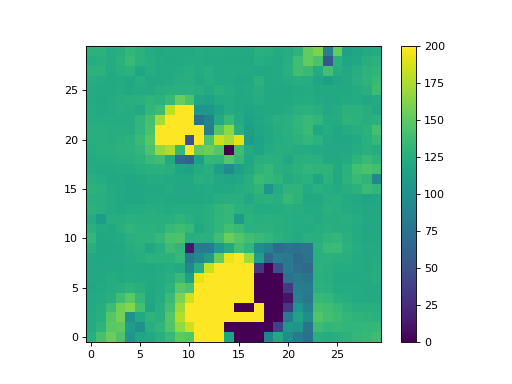

In [26]:
plt.figure()
plt.imshow(tpf.flux[100]-np.nansum(scene,axis=0),vmin=0,vmax=200,origin='lower')
plt.colorbar()

In [7]:
from scipy.optimize import minimize
from scipy import signal

def Delta_kernal(Scene,Image,Size=13):
    Basis, coeff_0 = Delta_basis(Size)
    bds = []
    for i in range(len(coeff_0)):
        bds += [(0,1)]
    
    res = minimize(Optimize_delta, coeff_0, args=(Basis,Scene,Image),bounds=bds)
    k = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)
    return k
        
def Optimize_delta(Coeff, Basis, Scene, Image):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)
    template = signal.fftconvolve(Scene, Kernal, mode='same')
    return np.nansum(abs(Image - template))

def Delta_basis(Size = 13):
    kernal = np.zeros((Size,Size))
    x,y = np.where(kernal==0)
    middle = int(len(x)/2)
    basis = []
    for i in range(len(x)):
        b = kernal.copy()
        if (x[i] == x[middle]) & (y[i] == y[middle]):
            b[x[i],y[i]] = 1
        else:
            b[x[i],y[i]] = 1
            b[x[middle],y[middle]] = -1
        basis += [b]
    basis = np.array(basis)
    coeff = np.ones(len(basis))
    return basis, coeff

In [16]:
t = np.nanmedian(tpf.flux,axis=0)
tt= t - np.percentile(t,15)

In [17]:
eh = tpf.flux - np.percentile(tpf.flux,15,axis=(1,2))[:,np.newaxis,np.newaxis]

In [21]:
s = np.nansum(scene,axis=0)
con = np.zeros_like(eh)
for i in range(1):
    k = Delta_kernal(s,tt,Size=19)
    con[i] = signal.fftconvolve(s, k, mode='same')

<IPython.core.display.Javascript object>


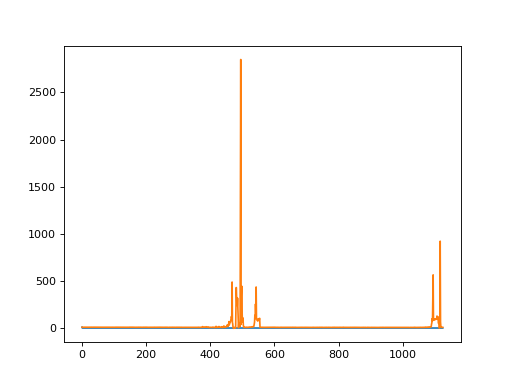

In [22]:
plt.figure()
plt.plot(con[:,14,14])
plt.plot(eh[:,14,14])

<IPython.core.display.Javascript object>


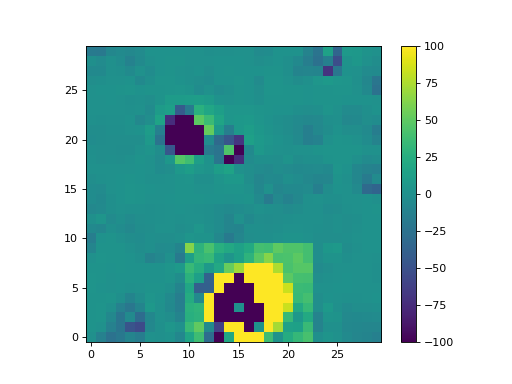

In [24]:
plt.figure()
plt.imshow(con[0]-tt,origin='lower',vmin=-100,vmax=100)
plt.colorbar()

In [12]:
plt.figure()
plt.imshow(con-tt,origin='lower',vmin=-100,vmax=100)
plt.colorbar()

<IPython.core.display.Javascript object>

TypeError: Invalid dimensions for image data

<IPython.core.display.Javascript object>


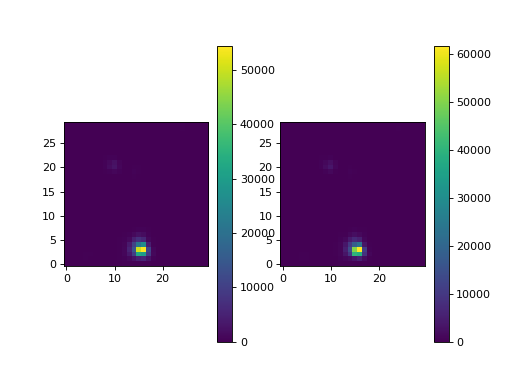

In [39]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(con,origin='lower')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(tt,origin='lower')
plt.colorbar()

Ra =  336#95.4586
Dec = 47#-51.2377
Size = 20
Maglim= 10
Bkg_limit = 20.5
Zeropoint = 20.44
Scale = 100
Interpolate = True
tpf = sd.Get_TESS(Ra,Dec,Size)
# pos returned as column row 
pos, gmag = sd.Get_Gaia(tpf,magnitude_limit=Maglim)
col = pos[:,0]
row = pos[:,1]

Tmag = gmag - 0.5
tcounts = 10**(-2/5*(Tmag - Zeropoint))
bkg = 10**(-2/5*(Bkg_limit - Zeropoint))

sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2])) + bkg
for i in range(len(pos)):
    if Interpolate:
        template = np.zeros((2*tpf.shape[1]*Scale,2*tpf.shape[2]*Scale))
        print('template shape ',template.shape)
        offset1 = int(0.5 * tpf.shape[1] * Scale)
        offset2 = int(0.5 * tpf.shape[2] * Scale)
        template[int(row[i]*Scale + offset1),int(col[i]*Scale+ offset2)] = tcounts[i]
        print(np.nansum(template))
        kernal = sd.Interp_PRF(row[i] + tpf.row, col[i] + tpf.column,tpf.camera,tpf.ccd,Scale)
        print(np.nansum(kernal))
        template = sd.signal.fftconvolve(template, kernal, mode='same')
        print(np.nansum(template))
        template = template[offset1:int(3*offset1),offset2:int(3*offset2)]
        #print('template shape ',template.shape)
        sources[i] = sd.Downsample(template,Scale)